# Run The Agent on Mountain Car

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [20]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [21]:
from util import random_observation_sequence, transform_observations
from train_agent import train_single_agent

In [22]:
from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [23]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [38]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np


class PriorModelBellman(keras.Model):

    def __init__(self,
                 observation_dim,
                 output_dim=1,
                 iterate_train=1,
                 discount_factor=0.99,
                 training_epochs=1,
                 show_training=True,
                 use_tanh_on_output=True):

        super(PriorModelBellman, self).__init__()
        self.observation_dim = observation_dim
        self.iterate_train = iterate_train
        self.discount_factor = discount_factor
        self.train_epochs = 1

        self.observations = []
        self.rewards = []

        self.train_epochs = training_epochs
        self.show_training = show_training

        # make the model
        transition_inputs = layers.Input(observation_dim)
        h = layers.Dense(observation_dim * 20, activation="silu")(transition_inputs)
        if use_tanh_on_output:
            h = layers.Dense(output_dim, activation="tanh")(h)
        else:
            h = layers.Dense(output_dim)(h)

        self.prior_model = keras.Model(transition_inputs, h, name="prior_model")
        self.prior_model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.MeanSquaredError())

    def call(self, observations):
        return self.prior_model(observations)

    def extrinsic_kl(self, observations):
        return 1.0 - self(observations)  # map from [-1, 1] to [2, 0]

    def train(self, observations, rewards):
        """
        :param observations: o_0, o_1, ... , o_n
        :param rewards: list with r_0, r_1, ... , r_n
        :return:
        """

        num_observations = len(observations)

        print(rewards)

        for i in range(self.iterate_train):

            # TODO Still seems a little strange that we add 0 to the end and discount the way we do but I think it makes sense. Check what predicted utilities are in practice
            utility_t = self.prior_model(observations)
            # utility_t_plus_one = tf.concat([utility_t[1:], tf.zeros((1, self.output_dim), dtype=utility_t.dtype)], axis=0)
            utility_t_plus_one = tf.concat([utility_t[1:], 0], axis=0)

            # OR just have constant gamma
            discount_factors = np.ones_like(utility_t_plus_one) * self.discount_factor

            # reducing discount factors through time
            # discount_factors = np.power([self.discount_factor]*num_observations, np.arange(num_observations)).reshape(observations.shape[0], 1)
            # discount_factors = np.flip(discount_factors)

            # print(discount_factors)

            # print(predicted_utility, pred_next_v)

            expected_utility = rewards_stacked + discount_factors * utility_t_plus_one

            # print(rewards_stacked)
            # print(discount_factors * utility_t_plus_one)

            self.prior_model.fit(observations, expected_utility, epochs=self.train_epochs, verbose=self.show_training)


In [39]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

# from vae_recurrent import VAE


class DAIFAgentRecurrent:

    def __init__(self,
                 prior_model,
                 vae,
                 tran,
                 habitual_action_net,
                 given_prior_mean=None,
                 given_prior_stddev=None,
                 agent_time_ratio=6,
                 actions_to_execute_when_exploring=2,
                 planning_horizon=15,
                 n_policies=1500,
                 n_cem_policy_iterations=2,
                 n_policy_candidates=70,
                 train_vae=True,
                 train_tran=True,
                 train_prior_model=True,
                 train_habit_net=True,
                 train_with_replay=True,
                 train_after_exploring=True,
                 use_kl_extrinsic=True,
                 use_kl_intrinsic=True,
                 use_FEEF=True,
                 use_fast_thinking=False,
                 uncertainty_tolerance=0.05,
                 habit_model_type="name_of_model"):

        super(DAIFAgentRecurrent, self).__init__()

        # parameters for slow policy planning
        self.planning_horizon = planning_horizon
        self.n_policy_candidates = n_policy_candidates
        self.n_policies = n_policies
        self.n_cem_policy_iterations = n_cem_policy_iterations

        # flags for whether or not we are training models or using pretrained models and when we should train
        self.train_vae = train_vae
        self.train_tran = train_tran
        self.train_habit_net = train_habit_net
        self.train_prior = train_prior_model
        self.train_with_replay = train_with_replay
        self.train_after_exploring = train_after_exploring

        # do we use the kl divergence for extrinsic vs intrinsic
        self.use_kl_intrinsic = use_kl_intrinsic
        self.use_kl_extrinsic = use_kl_extrinsic

        # do we use the FEEF or EFE?
        self.use_FEEF = use_FEEF

        # given prior values
        self.given_prior_mean = given_prior_mean
        self.given_prior_stddev = given_prior_stddev

        # full vae
        self.model_vae = vae
        self.tran = tran
        self.prior_model = prior_model
        self.habit_action_model = habitual_action_net

        # how much is the agents planning time compressed compared to the simulation time
        self.agent_time_ratio = agent_time_ratio
        self.actions_to_execute_when_exploring = actions_to_execute_when_exploring
        self.time_step = 0
        self.exploring = False

        # track the hidden state of the transition gru model so we can use it to train
        self.tran_hidden_state = None
        self.tran_hidden_state_pre_exploring = None
        self.prev_tran_hidden_state = None

        # store the full observations for the episode so we can train using replay
        self.full_observation_sequence = []
        self.full_action_sequence = []
        self.full_reward_sequence = []

        # store the observations while the agent is in exploration mode
        self.exploring_observation_sequence = []
        self.exploring_action_sequence = []
        self.exploring_reward_sequence = []

        # store the observations at the world time scale
        self.env_time_scale_observations = []

        self.policy_left_to_execute = [None]
        self.previous_observation = None
        self.action_being_executed = None
        self.action_being_executed = 0

        self.use_fast_thinking = use_fast_thinking
        self.habit_model_type = habit_model_type
        self.uncertainty_tolerance = uncertainty_tolerance


    def perceive_and_act(self, observation, reward, done):
        """
        The function called to have the agent interact with the environment
        We assume the agent gets a transformed/noisy observation from the environment and then returns an action

        TODO: possibly the agent returns some other information for logging and showing experiments

        :param observation:
        :param reward:
        :param done:
        :return:
        """

        # track the world time scale observation sequence
        self.env_time_scale_observations.append(observation)

        # if the episode is finished, then do any training on the full data set
        if done:

            if self.train_with_replay:
                print("training on full data")

                # add the final observation and reward we observed to the sequences
                self.full_observation_sequence.append(observation)
                self.full_reward_sequence.append(reward)

                # Call the training function on the observation sequences to train everything we need to train
                self.train_models(np.vstack(self.full_observation_sequence),
                                  np.vstack(self.full_action_sequence),
                                  np.array(self.full_reward_sequence),
                                  None)


        # Otherwise are we at a point where we can reconsider our policy and maybe train the world model
        elif self.time_step % self.agent_time_ratio == 0:

            # add the reward only if it's not the first observation
            if self.time_step != 0:
                self.full_reward_sequence.append(reward)

            # add the observation to the sequence
            self.full_observation_sequence.append(observation)

            # We only update the model during the episode when we were exploring using the planning method and we have executed all of the actions in the policy
            if self.exploring and len(self.policy_left_to_execute) == 0:

                # print("f", self.full_observation_sequence)
                # print("e", self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):])

                if self.train_after_exploring:

                    # the actions done while exploring were the last self.actions_to_execute_when_exploring
                    self.exploring_action_sequence = self.full_action_sequence[-1*self.actions_to_execute_when_exploring:]
                    self.exploring_reward_sequence = self.full_reward_sequence[-1*self.actions_to_execute_when_exploring:]
                    self.exploring_observation_sequence = self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):]

                    # Call the training function on the observation sequences to train everything we need to train
                    self.train_models(np.vstack(self.exploring_observation_sequence),
                                                np.vstack(self.exploring_action_sequence),
                                                np.array(self.exploring_reward_sequence),
                                                self.tran_hidden_state_pre_exploring)

                self.exploring = False


            # Predict the expected observation
            action_as_array = np.array(self.action_being_executed).reshape(1, self.tran.action_dim)
            expected_observation, self.tran_hidden_state = self.predict_next_observation(self.previous_observation, action_as_array, self.prev_tran_hidden_state)
            # pred_next_observation, next_tran_hidden_state = None, None
            # print(self.previous_observation, expected_observation, observation)
            # Now we select our action. If we aren't exploring then either we act out of habit or we might need to explore
            # I think I can check this based on whether or not there are actions left to execute in the current policy
            if not self.exploring:

                if self.use_fast_thinking and self.previous_observation is None:
                    # self.policy_left_to_execute = self.habit_action_model(observation)
                    self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
                    self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()  # tf tensor to list
                    print("fast thinking")

                # TDOD Fix this to work however it needs to
                # we need to see what the generative model now thinks about what the expected current observation is
                elif self.use_fast_thinking and np.allclose(observation, expected_observation, atol=self.uncertainty_tolerance):  # within some tolerance

                    self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
                    # self.policy_left_to_execute = self.policy_left_to_execute + np.random.normal(0, scale=self.habit_action_model.action_std_dev)
                    self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()

                    # self.tran_hidden_state = next_tran_hidden_state

                    print("fast thinking")

                # the generative model is surprised so we should use the slow deliberation for planning out a policy that balances exploration and exploitation
                else:
                    # print("slow thinking")
                    policy = self.select_policy(observation)
                    # print(policy.mean())
                    # TODO should we actually sample here?
                    policy = policy.mean().numpy()
                    policy = policy.reshape(policy.shape[0], self.tran.action_dim).tolist()
                    self.policy_left_to_execute = policy[0: self.actions_to_execute_when_exploring]

                    self.tran_hidden_state_pre_exploring = self.tran_hidden_state

                    self.exploring = True

                # print(observation)
                # print(pred_next_observation)

            # finally update the previous observation and action to be the one we just had/did
            self.previous_observation = observation
            self.prev_tran_hidden_state = self.tran_hidden_state
            self.action_being_executed = self.policy_left_to_execute[0]
            self.full_action_sequence.append(self.action_being_executed)
            self.policy_left_to_execute.pop(0)

        # final updates increment the current timestep and return the action specified by the policy
        self.time_step += 1

        return self.action_being_executed


    def predict_next_observation(self, obs, action, tran_hidden_state):

        # TODO: Fix this with the transition hidden states
        if obs is None:
            return None, None
        else:
            z_mean, z_std, z = self.model_vae.encoder(obs)
            # print(z_mean.shape)
            # print(action.shape)
            z_mean = z_mean.numpy()
            z_plus_action = np.concatenate([z_mean, action], axis=1)
            # print(z_mean)
            # print(action)
            # print(z_plus_action)

            z_plus_action = z_plus_action.reshape(1, 1, z_plus_action.shape[1])
            # print(z_plus_action)

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((z_plus_action, tran_hidden_state))

            next_observation = self.model_vae.decoder(next_latent_mean)
            # print(next_observation)
            return next_observation.numpy(), next_hidden_state


    # We use this function to reset the hidden state of the transition model when we want to train on the full data set
    def reset_tran_hidden_state(self):
        self.tran_hidden_state = None


    def reset_all_states(self):
        self.time_step = 0
        self.exploring = False

        # track the hidden state of the transition gru model so we can use it to train
        self.tran_hidden_state = None

        # store the full observations for the episode so we can train using replay
        self.complete_observation_sequence = []
        self.full_observation_sequence = []
        self.full_action_sequence = []
        self.full_reward_sequence = []

        # store the observations while the agent is in exploration mode
        self.exploring_observation_sequence = []
        self.exploring_action_sequence = []
        self.exploring_reward_sequence = []

        self.policy_left_to_execute = []
        self.previous_observation = None
        self.previous_action_executed = None


    def train_models(self, observations_full, actions, rewards, tran_hidden_state_pre_obs):

        pre_observations = observations_full[:-1]
        post_observations = observations_full[1:]

        # find the actual observed latent states using the vae
        pre_latent_mean, pre_latent_stddev, pre_latent = self.model_vae.encoder(pre_observations)
        post_latent_mean, post_latent_stddev, post_latent = self.model_vae.encoder(post_observations)

        #### TRAIN THE TRANSITION MODEL ####
        if self.train_tran:

            num_observations = pre_observations.shape[0]
            # observation_dim = pre_observations.shape[1]
            action_dim = actions.shape[1]
            latent_dim = self.model_vae.latent_dim

            # set up the input training data that we use to train the transition model
            z_train = np.concatenate([np.array(pre_latent_mean), actions], axis=1)

            # we use the sequence to find the right hidden states to use as input
            z_train_seq = z_train.reshape((1, num_observations, latent_dim + action_dim))
            z_train_singles = z_train.reshape(num_observations, 1, latent_dim + action_dim)

            # the previous hidden state is the memory after observing some sequences but it might be None if we're just starting
            if tran_hidden_state_pre_obs is None:
                tran_hidden_state_pre_obs = np.zeros((1, self.tran.hidden_units))

            # find the hidden states at t=0, t=1, t=2, ..., t=num_observations - 1
            _, _, _, h_states = self.tran((z_train_seq, tran_hidden_state_pre_obs))

            # squeeze so we make the shape [num_observations, hidden_units]
            h_states = tf.squeeze(h_states)

            # exclude the last state as this will become the hidden state later on. next hidden state will become our new memory
            h_states_for_training = h_states[:-1]
            # next_hidden_state = h_states[-1]

            # add the current hidden state we saved to the start. This has h0, h1, h2, .. h=num_observations - 1
            h_states_for_training = tf.concat([tran_hidden_state_pre_obs, h_states_for_training], axis=0)

            # use the hidden states with the pre and post observations to train transition model
            self.tran.fit((z_train_singles, h_states_for_training), (post_latent_mean, post_latent_stddev), epochs=self.tran.train_epochs, verbose=self.tran.show_training, batch_size=z_train_singles.shape[0])

            # now find the new predicted hidden state that we will use for finding the policy
            # TODO not sure if I should pass the old hidden state or reset it to 0
            _, _, final_hidden_state, h_states = self.tran((z_train_seq, tran_hidden_state_pre_obs))
            # _, _, final_hidden_state, _ = self.tran((z_train_seq, None))

            z_pred, _, _, _ = self.tran((z_train_singles, h_states_for_training))
            # print(h_states)
            # print(final_hidden_state)
            # print(h_states[:, -2, :])
            self.prev_tran_hidden_state = h_states[:, -2, :]
            self.tran_hidden_state = final_hidden_state


        #### TRAIN THE VAE ####
        if self.train_vae:
            # train the vae model on post_observations because these are all new
            # self.model_vae.fit(pre_observations_raw, epochs=self.vae_train_epochs, verbose=self.show_vae_training)
            self.model_vae.fit(pre_observations, epochs=self.model_vae.train_epochs, verbose=self.model_vae.show_training, batch_size=pre_observations.shape[0])


        #### TRAIN THE PRIOR MODEL ####
        # TODO fix how this part should work
        if self.train_prior:
            # self.prior_model.train(post_observations, rewards, verbose=self.show_prior_training)
            if max(rewards) > 0:
                # self.prior_model.train(post_observations, rewards)
                self.prior_model.train(post_latent_mean, rewards)


        #### TRAIN THE HABIT ACTION NET ####
        if self.train_habit_net:

            # prior_preferences_mean = tf.convert_to_tensor(self.given_prior_mean, dtype="float32")
            # prior_preferences_stddev = tf.convert_to_tensor(self.given_prior_stddev, dtype="float32")
            #
            # prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)
            #
            # external_efe = -1 * tf.math.log(prior_dist.prob(post_observations))
            # external_efe = external_efe.numpy().reshape(external_efe.shape[0], 1)
            #
            # one_over_external_efe = 1/external_efe
            #
            # ten_minus_external_efe = -1*external_efe + 10

            # ten_minus_external_efe = ten_minus_external_efe.numpy().reshape(ten_minus_external_efe.shape[0], 1)

            # one_over_external_efe = one_over_external_efe.numpy().reshape(one_over_external_efe.shape[0], 1)
            # print(one_over_external_efe.shape)

            # print(post_observations)
            # print(one_over_external_efe)

            # obs_utilities = self.prior_model(pre_observations)
            # obs_utilities = tf.reduce_sum(obs_utilities, axis=-1)
            # obs_utilities = obs_utilities.numpy().reshape(obs_utilities.shape[0], 1)
            # # print(obs_utilities)
            #
            # cum_rewards = compute_discounted_cumulative_reward(obs_utilities, self.habit_action_model.discount_factor)

            if self.habit_model_type == "PG":
                rewards = rewards.reshape(rewards.shape[0], 1)
                cum_rewards = compute_discounted_cumulative_reward(rewards, self.habit_action_model.discount_factor)
                rewards_to_train_on = cum_rewards

                # print(cum_rewards)
                # print(cum_rewards.sum())

                # rewards_to_train_on = rewards

                # DDPG and policy gradient interface with same function
                self.habit_action_model.train(pre_latent_mean, actions, rewards_to_train_on, post_latent_mean)

            if self.habit_model_type == "DDPG":
                self.habit_action_model.train(pre_latent_mean, actions, rewards, post_latent_mean)


    def select_fast_thinking_policy(self, observation):

        # TODO should you select the mean here?
        # _,  _, latent_state = self.model_vae.encoder(observation)
        latent_state,  _, _ = self.model_vae.encoder(observation)
        if self.habit_model_type == "DDPG":
            action = self.habit_action_model.actor_model(latent_state)
        elif self.habit_model_type == "PG":
            action = self.habit_action_model(latent_state)

        return action


    def select_policy(self, observation):
        """
        :param observation: needs to be [n, observation_dim] shape np array or tf tensor
        :return:
        """

        # TODO do you take the mean or that latent here?
        # get the latent state from this observation
        # TODO should I use the mean here?
        _,  _, latent_state = self.model_vae.encoder(observation)
        # latent_state,  _, _ = self.model_vae.encoder(observation)
        # latent_state = latent_state.numpy().reshape((1, latent_state.shape[0]))
        # print(latent_state)
        # print(latent_state)
        # select the policy
        policy_mean, policy_stddev = self.cem_policy_optimisation(latent_state)

        # return a distribution that we can sample from
        return tfp.distributions.MultivariateNormalDiag(loc=policy_mean, scale_diag=policy_stddev)


    # TODO Fix this so we can use different action dimensions
    def cem_policy_optimisation(self, latent_z):

        # need to change these two if the policy dimension changes
        mean_best_policies = tf.zeros((self.planning_horizon, self.tran.action_dim))
        std_best_policies = tf.ones((self.planning_horizon, self.tran.action_dim))

        # print(mean_best_policies)
        # print(mean_best_policies.shape)

        for i in range(self.n_cem_policy_iterations):
            policy_distr = tfp.distributions.MultivariateNormalDiag(loc=mean_best_policies, scale_diag=std_best_policies)
            policies = policy_distr.sample([self.n_policies])
            # print("p", policies.shape)
            policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)
            # policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)

            # project trajectory into the future using transition model and calculate FEEF for each policy
            policy_results = self.forward_policies(policies.numpy(), latent_z)
            FEEFs = self.evaluate_policy(*policy_results)

            # print("POLICIES", policies)
            # print("FEEFS", FEEFs)

            FEEFs = tf.convert_to_tensor(FEEFs)

            # sum over the timesteps to get the FEEF for each policy
            FEEFs_sum = tf.reduce_sum(FEEFs, axis=0)

            # multiply by -1 to find largest value which is euqivalent to smallest FEEF with top_k
            neg_FEEF_sum = -1*FEEFs_sum

            result = tf.math.top_k(neg_FEEF_sum, self.n_policy_candidates, sorted=False)
            min_FEEF_indices = result.indices

            # update the policy distributions
            mean_best_policies = tf.reduce_mean(tf.gather(policies, min_FEEF_indices), axis=0)
            std_best_policies = tf.math.reduce_std(tf.gather(policies, min_FEEF_indices), axis=0)


        # TODO not sure why we need all of this is with the x means? I think it's for training but maybe not

        # One last forward pass to gather the stats of the policy mean
        #FEEFs, next_x_means, next_x_stds = self._forward_policies(mean_best_policies.unsqueeze(1))
        # return mean_best_policies, std_best_policies, FEEFs.detach().squeeze(1), next_x_means.detach().squeeze(1), next_x_stds.detach().squeeze(1)

        return mean_best_policies, std_best_policies


    def forward_policies(self, policies, z_t_minus_one):
        """
        Forward propogate a policy and compute the FEEF of each policy
        :param z_t_minus_one:
        :return:
        """

        # stack up the new observation to have shape (self.n_policies, latent_dim) when z_t_minus is tensor with shape (1, latent_dim)
        prev_latent_mean = tf.squeeze(tf.stack([z_t_minus_one]*self.n_policies, axis=1))

        policy_posteriors = []
        policy_sds = []
        likelihoods = []
        z_means = []
        z_sds = []

        # get the starting hidden state that coressponds to the memory stored by the previous sequences. Should have shape (1, self.tran.num_hidden_units) for the observed sequence
        # extend the current hidden state to the number of policies present
        if self.tran_hidden_state is None:
            cur_hidden_state = np.zeros((self.n_policies, self.tran.hidden_units))
        else:
            cur_hidden_state = np.vstack([self.tran_hidden_state]*self.n_policies)

        # print(cur_hidden_state)

        # find the predicted latent states from the transition model
        for t in range(self.planning_horizon):

            # print(prev_latent_mean)
            # print(policies[:, t, :].shape)
            ob_plus_action = np.concatenate([prev_latent_mean, policies[:, t, :]], axis=1)
            tran_input = ob_plus_action.reshape((self.n_policies, 1, ob_plus_action.shape[1]))  # reshape to pass to GRU

            # print(tran_input.shape)

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((tran_input, cur_hidden_state))  # shape = [num policies, latent dim

            # update the hidden state for use with the next policies
            cur_hidden_state = next_hidden_state

            policy_posteriors.append(next_latent_mean)
            policy_sds.append(next_latent_sd)

            next_likelihoods = self.model_vae.decoder(next_latent_mean)
            likelihoods.append(next_likelihoods)

            next_posterior_means, next_posteriors_sds, next_posteriors_z = self.model_vae.encoder(next_likelihoods)
            z_means.append(next_posterior_means)
            z_sds.append(next_posteriors_sds)

            prev_latent_mean = next_latent_mean

        return policy_posteriors, policy_sds, likelihoods, z_means, z_sds


    def evaluate_policy(self, policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd):

        if self.use_FEEF:
            return self.FEEF(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)
        else:
            return self.EFE(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)


    def FEEF(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the FEEF for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        FEEFs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.

            if self.use_kl_extrinsic:
                likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

                if self.prior_model is None:

                    # TODO how exactly is the prior defined? After you apply transformations what is the prior
                    # create the prior distribution
                    prior_preferences_mean = tf.convert_to_tensor(np.stack([self.given_prior_mean]*self.n_policies), dtype="float32")
                    prior_preferences_stddev = tf.convert_to_tensor(np.stack([self.given_prior_stddev]*self.n_policies), dtype="float32")

                    prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

                    kl_extrinsic = tfp.distributions.kl_divergence(likelihood_dist, prior_dist)

                # Compute the extrinisc approximation with the prior model
                else:
                    kl_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
                    kl_extrinsic = tf.reduce_sum(kl_extrinsic, axis=-1)

            # if we don't use extrinsic set it to zero
            else:
                kl_extrinsic = tf.zeros(self.n_policies, dtype="float")

            # !!!! evaluate the KL INTRINSIC part !!!!
            if self.use_kl_intrinsic:

                policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
                predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

                kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            else:
                kl_intrinsic = tf.zeros(self.n_policies, dtype="float")

            # print("Extrinsic", kl_extrinsic)
            # print("Intrinsic", kl_intrinsic)

            FEEF = kl_extrinsic - kl_intrinsic

            FEEFs.append(FEEF)

        return FEEFs


    # TODO Find out how this works with the log probability extrinsic term
    def EFE(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the EFE for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        EFEs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.

            if self.use_kl_extrinsic:
                likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

                if self.prior_model is None:

                    # TODO how exactly is the prior defined? After you apply transformations what is the prior
                    # create the prior distribution
                    prior_preferences_mean = tf.convert_to_tensor(np.stack(self.given_prior_mean), dtype="float32")
                    prior_preferences_stddev = tf.convert_to_tensor(np.stack(self.given_prior_stddev), dtype="float32")

                    prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

                    # compute extrinsic prior preferences term
                    efe_extrinsic = -1 * tf.math.log(prior_dist.prob(predicted_likelihood))

                # TODO Can I use the learned prior model here?
                else:
                    # efe_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
                    efe_extrinsic = self.prior_model.extrinsic_kl(predicted_posterior)
                    efe_extrinsic = tf.reduce_sum(efe_extrinsic, axis=-1)

            # if we don't use extrinsic set it to zero
            else:
                efe_extrinsic = tf.zeros(self.n_policies, dtype="float")

            # !!!! evaluate the KL INTRINSIC part !!!!
            if self.use_kl_intrinsic:

                policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
                predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

                kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            else:
                kl_intrinsic = tf.zeros(self.n_policies, dtype="float")

            # print("EX", efe_extrinsic)
            # print("IN", kl_intrinsic)

            EFE = efe_extrinsic - kl_intrinsic

            EFEs.append(EFE)

        return EFEs

In [40]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=True)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=True)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, show_training=True)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

In [41]:

# daifa = DAIFAgentRecurrent(None,
#                            vae,
#                            tran,
#                            habit_net,
#                            scaled_prior_mean,
#                            prior_stddev,
#                            planning_horizon=pln_hrzn,
#                            use_kl_extrinsic=True,
#                            use_kl_intrinsic=True,
#                            use_FEEF=False,
#                            train_habit_net=True,
#                            train_prior_model=False,
#                            train_with_replay=True,
#                            train_after_exploring=True,
#                            use_fast_thinking=False)

In [42]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=False,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=False,
                           habit_model_type="PG")



daifa.train_prior = True
daifa.prior_model.show_training = True

In [43]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[-0.48151875  0.        ]
Epoch 1/2


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 1s 528ms/step - kl_loss: 0.0653
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.0598
Epoch 1/2
1/1 [==============================] - 0s 237ms/step - loss: 45.8163 - reconstruction_loss: 38.4364 - kl_loss: 7.3799
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 21.5488 - reconstruction_loss: 14.2295 - kl_loss: 7.3193
Epoch 1/2
1/1 [==============================] - 0s 94ms/step - loss: -81.7286
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -83.3360
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.0248
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.0242
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: 121.4684 - reconstruction_loss: 113.6694 - kl_loss: 7.7990
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: 48.4176 - reconstruction_loss: 40.6887 - kl_loss: 7.7289
Epoch 1/2
1/1 [============

InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [19,1] vs. shape[1] = [] [Op:ConcatV2] name: concat

In [30]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [31]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5360193  0.       ]
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.6375
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 0.6102
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -45.6262
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -45.3539


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.9904
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.9144
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -52.5604
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: -52.2518
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.6778
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.6394
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -52.9761
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -52.7046
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4562
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4790
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -40.5776
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -40.5031
Epoch 1/2
1/1 [==============================] - 0s 2ms/st

In [190]:
daifa.train_prior = False
daifa.prior_model.show_training = False

# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.001)
# actor_optimizer = tf.keras.optimizers.Adam(0.0005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer, observation_dim=latent_dim)
#
# daifa.habit_model_type = "DDPG"

# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
# daifa.habit_model_type = "PG"
#
# daifa.habit_action_model = habit_net

daifa.habit_action_model.show_training = True
daifa.train_habit_net = False
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = False

In [161]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.59662616  0.        ]
Epoch 1/2
1/1 [==============================] - 0s 6ms/step - kl_loss: 3.2428
Epoch 2/2
1/1 [==============================] - 0s 3ms/step - kl_loss: 3.2278


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch 1/2
1/1 [==============================] - 0s 96ms/step - loss: -47.8857
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -48.2584
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.4109
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.3716
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -119.0805
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -120.6901
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.0798
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.0884
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -22.1601
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -22.4742
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.0450
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 1.0546
Epoch 1/2
1/1 [==============================] - 0s 2ms

In [37]:
daifa.habit_action_model.show_training = True
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=True)

/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See

Episode 1
[-0.5802331  0.       ]
fast thinking
fast thinking
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 7ms/step - kl_loss: 1.5104
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.5189
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -30.5062
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: -30.4193
fast thinking
fast thinking
fast thinking
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4819
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4896
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -7.6822
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: -7.6606
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.7443
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.7650
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: -

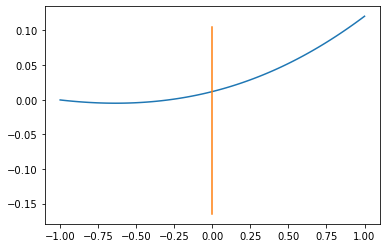

In [32]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

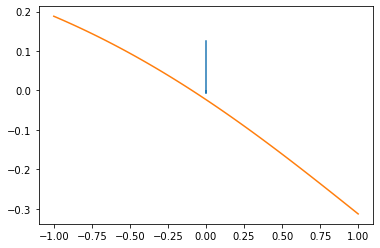

In [33]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

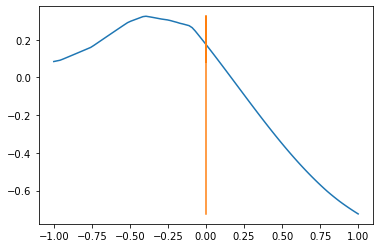

In [34]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.habit_action_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

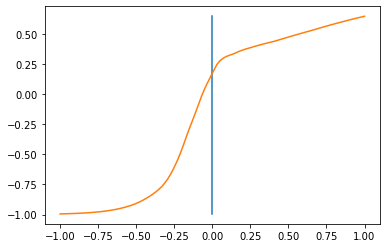

In [35]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.habit_action_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [36]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

obs_stddev = [0.05, 0.05]
# obs_stddev = [0, 0]


t_max = 999

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    env.render()

    done = False
    rewards = []

    t = 0
    while not done:

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        latent_mean, _, _ = daifa.model_vae.encoder(obs)
        # action = daifa.habit_action_model.actor_model(latent_mean)
        action = daifa.habit_action_model(latent_mean)
        action = action.numpy()

        for k in range(daifa.agent_time_ratio):
            obs, reward, done, info = env.step(action)

            env.render()

            # print(obs)

            rewards.append(reward)

            t += 1

            if t == t_max:
                done = True
                break
            elif done:
                break

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)


env.close()

/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See

292
success
94.28041628059832
246
success
96.14228589939898
237
success
95.62813478373828


/Users/Ethan/python_repos/gym/gym/envs/classic_control/continuous_mountain_car.py:173: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.state = np.array([position, velocity], dtype=np.float32)


208
success
93.572889227936
234
success
96.29431717532314
195
success
94.50258531396743
196
success
95.35582070840101
158
success
96.50849545897857
158
success
96.55365197283321
199
success
95.70399826793675


In [118]:
num_seqs = 20
seq_length = 500
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []
actions = []

pre_obs = []
post_obs = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)
    actions.append(a)

    pre_obs.append(o[:-1])
    post_obs.append(o[1:])


    observations.append(o)
    # ob_seqs.append(train)
    # next_obs.append(test)

observations = np.vstack(observations)
actions = np.vstack(actions)

pre_obs = np.vstack(pre_obs)
post_obs = np.vstack(post_obs)


print(pre_obs.shape, actions.shape)

(10998, 2) (10998, 1)


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [119]:
agent.habit_action_model(pre_obs)

NameError: name 'agent' is not defined

In [ ]:
observations

In [ ]:
res = agent.model_vae(observations)
res

In [ ]:
m, s, z_pre = agent.model_vae.encoder(pre_obs)
m, s, z_post = agent.model_vae.encoder(post_obs)
z_pre

In [ ]:
z_plus_a = np.concatenate([z_pre, actions], axis=1)
z_plus_a

In [ ]:
agent.tran((z, np.zeros_like(z)))

## Test without the replay training

In [ ]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])
vae = VAE(enc, dec, 2,  [0, 0], [0.3, 0.3], llik_scaling=1)

tran = TransitionGRU(2, 1, 12, 20, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

daifa = DAIFAgentRecurrent(None,
                           vae,
                           tran,
                           scaled_prior_mean,
                           prior_stddev,
                           planning_horizon=5,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=True,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

scaled_prior_mean

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
agent, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=40, action_repeats=6, num_actions_to_execute=2, train_on_full_data=False, show_replay_training=False)

In [ ]:
observations

In [ ]:
res = agent.model_vae(observations)
res

## Test with the prior model FEEF

In [ ]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])
vae = VAE(enc, dec, 2, [0, 0], [0.3, 0.3], llik_scaling=1, recon_stddev=0.05)

pl_hoz = 5
latent_dim = 2

tran = TransitionGRU(2, 1, 12, 2*latent_dim*pl_hoz, 2)

# unscaled prior mean and prior stddev
prior_model = PriorModelBellman(2)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           None,
                           None,
                           train_prior_model=True,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=True,
                           vae_train_epochs=1,
                           tran_train_epochs=1)

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
agent, results = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=40, action_repeats=6, num_actions_to_execute=5, train_on_full_data=False, show_replay_training=True, train_during_episode=True, train_vae=True, train_tran=True, train_prior=True)

## Test the models produced

In [ ]:
num_seqs = 20
seq_length = 300
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    test = o[-1]

    observations.append(o)
    ob_seqs.append(train)
    next_obs.append(test)

# ob_seqs = np.array(ob_seqs)
# next_obs = np.array(next_obs)

observations = np.vstack(observations)
# observations = observations.reshape((num_seqs*(seq_length+1), ob_dim))

# ob_seqs_stddev = np.ones_like(ob_seqs_flat)
# next_obs_stddev = np.ones_like(ob_seqs_flat)

observations.shape

In [ ]:
observations

In [ ]:
agent.model_vae(observations)

In [ ]:
tf.reduce_mean(agent.model_vae.compute_loss(observations))

In [ ]:
observations

In [ ]:
agent.prior_model(observations)

In [ ]:
agent.prior_model.extrinsic_kl(observations)

## Test EFE

In [ ]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])
vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=1)

pl_hoz = 5
latent_dim = 2

tran = TransitionGRU(2, 1, 12, 2*pl_hoz*latent_dim, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

# unscaled prior mean and prior stddev
prior_model = PriorModelBellman(2)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

# without prior model
daifa = DAIFAgentRecurrent(None,
                           vae,
                           tran,
                           scaled_prior_mean,
                           prior_stddev,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

# with prior model
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           None,
                           None,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

scaled_prior_mean

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
agent, results = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, action_repeats=10, num_actions_to_execute=2, train_on_full_data=True)

In [ ]:
## Test the models produced
num_seqs = 20
seq_length = 300
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    test = o[-1]

    observations.append(o)
    ob_seqs.append(train)
    next_obs.append(test)

# ob_seqs = np.array(ob_seqs)
# next_obs = np.array(next_obs)

observations = np.vstack(observations)
# observations = observations.reshape((num_seqs*(seq_length+1), ob_dim))

# ob_seqs_stddev = np.ones_like(ob_seqs_flat)
# next_obs_stddev = np.ones_like(ob_seqs_flat)

observations.shape

In [ ]:
observations

In [ ]:
agent.model_vae(observations)
## Test EFE

## Testing the Identity VAE

In [ ]:
enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

hidden_size = 2*2*15  # 2*latent_dim * planning_size
tran = TransitionGRU(2, 1, 12, hidden_size, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=5)

In [ ]:
out = agent.tran((ob_seqs[0:1], None))
out

In [ ]:
t = ob_seqs[0:1, -1].reshape(1,1,3)
h = out[3]
h = h[0, -2, :]
h = h.numpy().reshape(1,30)
h

In [ ]:
agent.tran((t, h))

In [ ]:
ob_seqs[0:1]

## Test to see how the agent trains on standard observation data

In [ ]:
enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

hidden_size = 2*2*15  # 2*latent_dim * planning_size
tran = TransitionGRU(2, 1, 12, hidden_size, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, vae_train_epochs=1, tran_train_epochs=2)

In [ ]:
env = gym.make('MountainCarContinuous-v0')
success, agent, t, pre_obs, post_obs, acts = run_episode(env, daifa, observation_max, observation_min, observation_noise_stddev)

In [ ]:
pre_np = np.array(pre_obs)
a = np.array(acts)
a.shape
pre_a = np.concatenate([pre_np, a], axis=2)

In [ ]:
print(a.max(), a.min())

In [ ]:
pre_a

In [ ]:
post_obs_to_predict = np.array(post_obs)[:, 14, :]
post_obs_to_predict

In [ ]:
agent.tran((pre_a, None))

In [ ]:
post_obs_to_predict

## Examine training the model on the observation data

Does it eventually converge to a good model

In [ ]:
num_train_runs = 1
for i in range(num_train_runs):

    for j in range(len(pre)):
        pre = pre_obs[j]
        post = post_obs[j]
        actions = acts[j]

        daifa.train(pre, post, actions, None, verbose=1)

In [ ]:
daifa.cem_policy_optimisation(np.array([0.5, 0.1]))

In [ ]:
daifa.cem_policy_optimisation

## Test the FEEF computations

In [ ]:
# enc = create_encoder(2, 2, [20])
# dec = create_decoder(2, 2, [20])
# vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

tran = TransitionGRU(2, 1, 12, 60, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0, 0])  # no noise on prior

print(scaled_prior_mean)

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, planning_horizon=15, n_policy_candidates=70, n_policies=1500, n_cem_policy_iterations=5)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev,
                                                num_episodes=1)

In [ ]:
def test_policy(agent, env, policy, action_repeats):

    observation = env.reset()
    obs = transform_observations(observation, observation_max, observation_min, [0, 0])

    z_t_minus_1 = obs
    p, s = agent.cem_policy_optimisation(z_t_minus_1)
    p
    print(obs)
    print(p)

    for action in p:
        for t in range(action_repeats):
            res = env.step(np.array([action]))
            print(res)

In [ ]:
z_t_minus_1 = np.array([0, 0])
p, s = agent.cem_policy_optimisation(z_t_minus_1)
p

agent.forward_policies(p, z_t_minus_1)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

test_policy(agent, env, p.numpy(), 6)

In [ ]:
z_t_minus_1 = np.array([-0.27691475,  0.01688306])
p, s = agent.cem_policy_optimisation(z_t_minus_1)
p

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

from vae_recurrent import VAE


class DAIFAgentRecurrent:

    def __init__(self,
                 prior_model,
                 vae,
                 tran,
                 given_prior_mean,
                 given_prior_stddev,
                 planning_horizon=15,
                 n_policies=1500,
                 n_cem_policy_iterations=2,
                 n_policy_candidates=70,
                 tran_train_epochs=1,
                 vae_train_epochs=1,
                 agent_time_ratio=6,
                 train_vae=True,
                 train_tran=True):

        super(DAIFAgentRecurrent, self).__init__()

        self.prior_model = prior_model
        self.planning_horizon = planning_horizon
        self.n_policy_candidates = n_policy_candidates
        self.n_policies = n_policies
        self.n_cem_policy_iterations = n_cem_policy_iterations

        self.vae_train_epochs = vae_train_epochs
        self.tran_train_epochs = tran_train_epochs
        self.train_vae = train_vae
        self.train_tran = train_tran

        self.given_prior_mean = given_prior_mean
        self.given_prior_stddev = given_prior_stddev

        # full vae
        self.model_vae = vae
        self.model_vae.compile(optimizer=tf.keras.optimizers.Adam())

        # transition
        # takes action plus last state and outputs next latent state
        self.tran = tran
        self.tran.compile(optimizer=tf.keras.optimizers.Adam())

        self.hidden_state = None

        # how much is the agents planning time compressed compared to the simulation time
        self.agent_time_ratio = agent_time_ratio


    def select_policy(self, observation):

        policy_mean, policy_stddev = self.cem_policy_optimisation(observation)

        # return a distribution that we can sample from
        return tfp.distributions.MultivariateNormalDiag(loc=policy_mean, scale_diag=policy_stddev)


    def train(self, pre_observations_raw, post_observations_raw, actions_complete, rewards, verbose=0):

        # compress the observations based on the agents time compression factor
        # pre_observations = pre_observations_raw[::self.agent_time_ratio]  # for example take every 6th element
        # post_observations = np.array([post_observations_raw[i] for i in range(len(post_observations_raw)) if i % self.agent_time_ratio == self.agent_time_ratio - 1])
        #
        # print(pre_observations_raw)
        # print(pre_observations)
        # print(post_observations_raw)
        # print(post_observations)

        pre_observations = pre_observations_raw
        post_observations = post_observations_raw

        # only look at the first n actions that we took
        actions = actions_complete[0: len(pre_observations)]

        num_observations = pre_observations.shape[0]
        observation_dim = pre_observations.shape[1]
        action_dim = actions.shape[1]
        # action_dim = 1  # TODO fix this to allow different actions

        # find the actual observed latent states using the vae
        pre_latent_mean, pre_latent_stddev, pre_latent = self.model_vae.encoder(pre_observations)
        post_latent_mean, post_latent_stddev, post_latent = self.model_vae.encoder(post_observations)

        # set up the input training data that we use to train the transition model
        z_train = np.concatenate([np.array(pre_latent_mean), np.array(actions)], axis=1)

        # we use the sequence to find the right hidden states to use as input
        z_train_seq = z_train.reshape((1, num_observations, observation_dim + action_dim))
        z_train_singles = z_train.reshape(num_observations, 1, observation_dim + action_dim)

        # the previous hidden state is the memory after observing some sequences but it might be None
        if self.hidden_state is None:
            self.hidden_state = np.zeros((1, self.tran.hidden_units))

        if self.train_tran:
            # find the hidden states at t=0, t=1, t=2, ..., t=num_observations - 1
            _, _, _, h_states = self.tran((z_train_seq, self.hidden_state))


            # squeeze so we make the shape [num_observations, hidden_units]
            h_states = tf.squeeze(h_states)

            # exclude the last state as this will become the hidden state later on. next hidden state will become our new memory
            h_states_for_training = h_states[:-1]
            # next_hidden_state = h_states[-1]

            # add the current hidden state we saved to the start. This has h0, h1, h2, .. h=num_observations - 1
            h_states_for_training = tf.concat([self.hidden_state, h_states_for_training], axis=0)


            # use the hidden states with the pre and post observations to train transition model
            self.tran.fit((z_train_singles, h_states_for_training), (post_latent_mean, post_latent_stddev), epochs=self.tran_train_epochs, verbose=verbose)

        # now find the new predicted hidden state that we will use for finding the policy
        # TODO not sure if I should pass the old hidden state or reset it to 0
        _, _, final_hidden_state, _ = self.tran((z_train_seq, self.hidden_state))
        # _, _, final_hidden_state, _ = self.tran((z_train_seq, None))

        self.hidden_state = final_hidden_state

        #### TRAIN THE VAE ####
        if self.train_vae:
            # train the vae model on post_observations because these are all new
            self.model_vae.fit(post_observations, epochs=self.vae_train_epochs, verbose=verbose)



    def cem_policy_optimisation(self, z_t_minus_one):

        # need to change these two if the policy dimension changes
        mean_best_policies = tf.zeros(self.planning_horizon)
        std_best_policies = tf.ones(self.planning_horizon)

        for i in range(self.n_cem_policy_iterations):
            policy_distr = tfp.distributions.MultivariateNormalDiag(loc=mean_best_policies, scale_diag=std_best_policies)
            policies = policy_distr.sample([self.n_policies])
            policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)

            # project trajectory into the future using transition model and calculate FEEF for each policy
            policy_results = self.forward_policies(policies.numpy(), z_t_minus_one)
            FEEFs = self.evaluate_policy(*policy_results)

            FEEFs = tf.convert_to_tensor(FEEFs)

            # sum over the timesteps to get the FEEF for each policy
            FEEFs_sum = tf.reduce_sum(FEEFs, axis=0)

            # multiply by one to find largest value which is euqivalent to smallest FEEF with top_k
            neg_FEEF_sum = -1*FEEFs_sum

            result = tf.math.top_k(neg_FEEF_sum, self.n_policy_candidates, sorted=False)
            min_FEEF_indices = result.indices

            # update the policy distributions
            mean_best_policies = tf.reduce_mean(tf.gather(policies, min_FEEF_indices), axis=0)
            std_best_policies = tf.math.reduce_std(tf.gather(policies, min_FEEF_indices), axis=0)


        # TODO not sure why we need all of this is with the x means? I think it's for training but maybe not

        # One last forward pass to gather the stats of the policy mean
        #FEEFs, next_x_means, next_x_stds = self._forward_policies(mean_best_policies.unsqueeze(1))
        # return mean_best_policies, std_best_policies, FEEFs.detach().squeeze(1), next_x_means.detach().squeeze(1), next_x_stds.detach().squeeze(1)

        print(z_t_minus_one)
        print(mean_best_policies)
        return mean_best_policies, std_best_policies


    def forward_policies(self, policies, z_t_minus_one):
        """
        Forward propogate a policy and compute the FEEF of each policy
        :param z_t_minus_one:
        :return:
        """

        # stack up the new observation to have shape [self.n_policies, len(z_t_minus_one)]
        prev_latent_mean = np.stack([z_t_minus_one]*self.n_policies)

        policy_posteriors = []
        policy_sds = []
        likelihoods = []
        z_means = []
        z_sds = []

        # get the starting hidden state that coressponds to the memory stored by the previous sequences. Should have shape (1, self.tran.num_hidden_units) for the observed sequence
        # extend the current hidden state to the number of policies present
        if self.hidden_state is None:
            cur_hidden_state = np.zeros((self.n_policies, self.tran.hidden_units))
        else:
            cur_hidden_state = np.vstack([self.hidden_state]*self.n_policies)

        # print(cur_hidden_state)

        # find the predicted latent states from the transition model
        for t in range(self.planning_horizon):

            ob_plus_action = np.concatenate([prev_latent_mean, policies[:, t].reshape(self.n_policies, 1)], axis=1)
            tran_input = ob_plus_action.reshape((self.n_policies, 1, ob_plus_action.shape[1]))  # reshape to pass to GRU

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((tran_input, cur_hidden_state))  # shape = [num policies, latent dim

            # update the hidden state for use with the next policies
            cur_hidden_state = next_hidden_state

            policy_posteriors.append(next_latent_mean)
            policy_sds.append(next_latent_sd)

            next_likelihoods = self.model_vae.decoder(next_latent_mean)
            likelihoods.append(next_likelihoods)

            next_posterior_means, next_posteriors_sds, next_posteriors_z = self.model_vae.encoder(next_likelihoods)
            z_means.append(next_posterior_means)
            z_sds.append(next_posteriors_sds)

            prev_latent_mean = next_latent_mean

        return policy_posteriors, policy_sds, likelihoods, z_means, z_sds


    def evaluate_policy(self, policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd):

        return self.FEEF(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)


    def FEEF(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the FEEF for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        FEEFs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.
            likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

            if self.prior_model is None:

                # TODO how exactly is the prior defined? After you apply transformations what is the prior
                # create the prior distribution
                prior_preferences_mean = tf.convert_to_tensor(np.stack([self.given_prior_mean]*self.n_policies), dtype="float32")
                prior_preferences_stddev = tf.convert_to_tensor(np.stack([self.given_prior_stddev]*self.n_policies), dtype="float32")

                prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

            # TODO Fix the learned prior model
            else:
                prior_dist = self.prior_model()

            kl_extrinsic = tfp.distributions.kl_divergence(likelihood_dist, prior_dist)

            # !!!! evaluate the KL INTRINSIC part !!!!
            policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
            predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

            kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            FEEF = kl_extrinsic - kl_intrinsic

            FEEFs.append(FEEF)

        return FEEFs


    def EFE(self, policy_posteriors, predicted_likelihood, predicted_posterior):
        """
        Compute the EFE for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """
        pass

## Testing with a pretrained transition model

This works well! So the problem can't lie with the transition model.

In [ ]:
# enc = create_encoder(2, 2, [20])
# dec = create_decoder(2, 2, [20])
# vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

tran = TransitionGRU(2, 1, 12, 60, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0.07]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0, 0])  # no noise on prior

print(scaled_prior_mean)

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, train_vae=False)

In [ ]:
num_seqs = 200
seq_length = 500
ob_seqs = []
next_obs = []
next_obs_stddev = []
actions = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, seq_length, epsilon=0.2)

    o = transform_observations(o, observation_max, observation_min, [0, 0])

    # train = np.concatenate([o[:-1], a], axis=1)
    train = o[:-1]
    test = o[1:]

    actions.append(a)
    ob_seqs.append(train)
    next_obs.append(test)

    ob_seqs_stddev = np.ones_like(train)
    next_stddev = np.ones_like(test)

    next_obs_stddev.append(next_stddev)

In [ ]:
for i in range(num_seqs):

    pre = ob_seqs[i]
    next = next_obs[i]
    acts = actions[i]

    next_sd = next_obs_stddev[i]

    daifa.train(pre, next, acts, None, verbose=1)

In [ ]:
num_seqs = 20
seq_length = 150
ob_seqs = []
next_obs = []

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, seq_length, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, [0, 0])

    train = np.concatenate([o[:-1], a], axis=1)
    test = o[-1]

    ob_seqs.append(train)
    next_obs.append(test)

ob_seqs = np.array(ob_seqs)[:, -5:, :]
next_obs = np.array(next_obs)
ob_seqs.shape

ob_seqs_stddev = np.ones_like(ob_seqs)
next_obs_stddev = np.ones_like(next_obs)

ob_seqs.shape

In [ ]:
daifa.tran((ob_seqs, None))

In [ ]:
next_obs

That looks fantastic!!! With enough data the transition model is training very well

In [ ]:
daifa.hidden_state

In [ ]:
z_t_minus_1 = np.array([0.4, 0.5])
daifa.hidden_state = None
p, s = daifa.cem_policy_optimisation(z_t_minus_1)
p

In [ ]:
daifa.tran((np.array([[[0.4, 0.5, 1]]]), None))

In [ ]:
env = gym.make('MountainCarContinuous-v0')

daifa.train_tran = False
daifa.train_vae = False

daifa.hidden_state = None

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev,
                                                num_episodes=1)